In [2]:
import os
if not os.path.exists('../input'):
    !kaggle competitions download -c ultrasound-nerve-segmentation -wp nerve
    !mkdir ../input
    !mv nerve/ultrasound-nerve-segmentation/* ../input
    !cd ../input; ls *.zip|awk -F'.zip' '{print "unzip "$0" -d "$1}'|sh > null
    !mkdir ../input/csvs
    !mv ../input/*.csv ../input/csvs
    !mv ../input/csvs/*/*.csv ../input/

train_masks.csv.zip: Downloaded 749KB of 749KB
sample_submission.csv.zip: Downloaded 6KB of 6KB
test.zip: Downloaded 1GB of 1GB1GB
train.zip: Downloaded 1GB of 1GB1GB


Here is the starting point for processing ultrasound nerve segmentation data from Kaggle

In [6]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
from skimage.io import imread
import matplotlib.pyplot as plt
IMAGE_DIR = '../input/train/train/'
# functions copied from https://www.kaggle.com/chefele/ultrasound-nerve-segmentation/animated-images-with-outlined-nerve-area
def to_mask_path(f_image):
    # Convert an image file path into a corresponding mask file path 
    dirname, basename = os.path.split(f_image)
    maskname = basename.replace(".tif", "_mask.tif")
    return os.path.join(dirname, maskname)
def get_patient_images(patient):
    # Return a dict of patient images, i.e. dict[filepath]
    f_path = IMAGE_DIR + '%i_*.tif' % patient 
    f_ultrasounds = [f for f in glob.glob(f_path) if 'mask' not in f]
    images = {os.path.basename(f): (imread(f), imread(to_mask_path(f))>0) for f in f_ultrasounds}
    return images

# Load and Preview Images

In [7]:
image_dict = get_patient_images(patient=41)

Text(0.5,1,'Segmented Nerve')

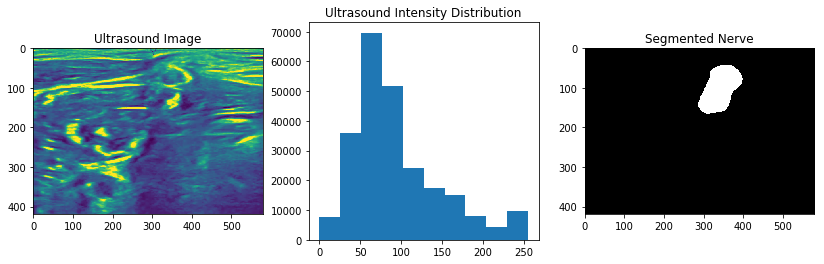

In [8]:
%matplotlib inline
us_image, us_mask = image_dict['41_40.tif']
fig, (ax1, ax2 ,ax3) = plt.subplots(1,3, figsize = (14,4))
ax1.imshow(us_image)
ax1.set_title('Ultrasound Image')
ax2.hist(us_image.ravel())
ax2.set_title('Ultrasound Intensity Distribution')
ax3.imshow(us_mask, cmap = 'bone')
ax3.set_title('Segmented Nerve')

## Just focus on the nerve
Show the segmentation of the nerve and the intensity inside that region

Text(0.5,1,'Ultrasound Intensity Distribution')

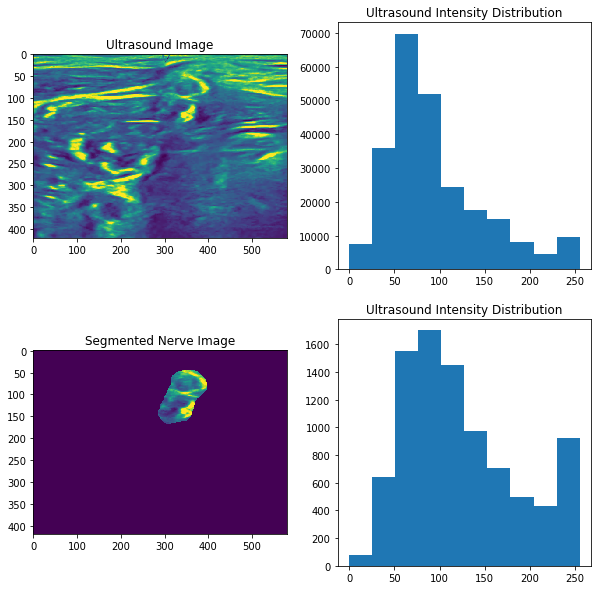

In [9]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (10,10))
ax1.imshow(us_image)
ax1.set_title('Ultrasound Image')
counts, bins, _ = ax2.hist(us_image.ravel())
ax2.set_title('Ultrasound Intensity Distribution')
ax3.imshow(us_image*us_mask)
ax3.set_title('Segmented Nerve Image')
ax4.hist(us_image[us_mask], bins = bins) # use the same bins again
ax4.set_title('Ultrasound Intensity Distribution')

# Simple Segmentation
We see too peaks in this histogram, lets try segmenting between them

Text(0.5,1,'Segmented Nerve')

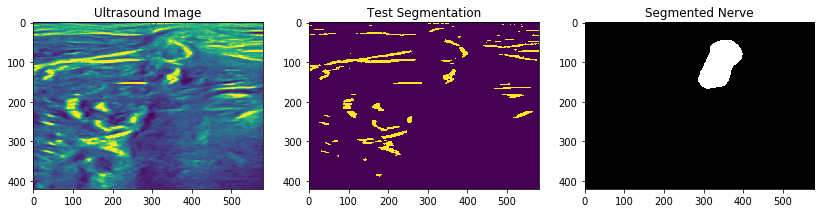

In [10]:
%matplotlib inline
fig, (ax1, ax2 ,ax3) = plt.subplots(1,3, figsize = (14,4))
ax1.imshow(us_image)
ax1.set_title('Ultrasound Image')
ax2.imshow(us_image>210)
ax2.set_title('Test Segmentation')
ax3.imshow(us_mask, cmap = 'bone')
ax3.set_title('Segmented Nerve')

# Scoring the Result
We can use the ROC curve to score the result and see how accurately we classified the images

In [11]:
from sklearn.metrics import roc_curve, auc # roc curve tools
ground_truth_labels = us_mask.ravel() # we want to make them into vectors
score_value = us_image.ravel()/255.0 # we want to make them into vectors
fpr, tpr, _ = roc_curve(ground_truth_labels,score_value)
roc_auc = auc(fpr,tpr)

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
ax.legend(loc="lower right")

# Gaussian Filter
Here we apply a gaussian filter and see how the performance changes

In [ ]:
%matplotlib inline
from skimage.filters import gaussian
gus_image = gaussian(us_image/255,sigma = 25)*255
fig, (ax1, ax2 ,ax3) = plt.subplots(1,3, figsize = (14,4))
ax1.imshow(gus_image)
ax1.set_title('Gaussian Filtered Image')
ax2.imshow(gus_image>120)
ax2.set_title('Test Segmentation')
ax3.imshow(us_mask, cmap = 'bone')
ax3.set_title('Segmented Nerve')

In [ ]:
ground_truth_labels = us_mask.ravel() # we want to make them into vectors
score_value = gus_image.ravel()/255.0 # we want to make them into vectors
fpr_gus, tpr_gus, _ = roc_curve(ground_truth_labels,score_value)
roc_auc_gus = auc(fpr_gus,tpr_gus)
fig, ax = plt.subplots(1,1)
ax.plot(fpr, tpr, label='Raw ROC curve (area = %0.2f)' % roc_auc)
ax.plot(fpr_gus, tpr_gus, label='Gaussian ROC curve (area = %0.2f)' % roc_auc_gus)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
ax.legend(loc="lower right")

# Tasks 

 1. How can you improve filtering in this analysis?
  - Which filter elements might improve the area under the ROC?
 3. Try making workflows to test out a few different filters
 - Where might morphological operations fit in?
 - How can you make them part of this workflow as well?
 6. (Challenge) Try and use the optimize toolbox of scipy with the fmin
    function (from scipy.optimize import fmin) to find the optimum
    parameters for the highers area (hint: fmin finds the minimum value)